In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import seaborn as sns

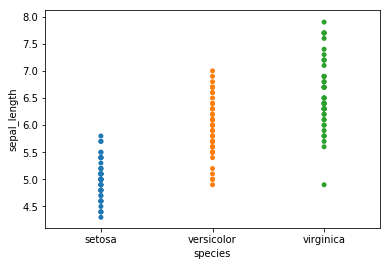

In [2]:
iris = sns.load_dataset("iris")
iris.head()
sns.stripplot(x='species', y='sepal_length', data=iris, jitter=False)#True)
#sns.pairplot(iris, hue='species', diag_kind='kde')

In [3]:
#对数据进行编码，修改成DataFrame格式
df = iris.query("species == ('setosa', 'versicolor')")
y1 = pd.Categorical(df['species']).codes
yn = ['sepal_length', 'sepal_width']
x1 = df[yn].values
#print(x0, y0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 11000/11000 [01:09<00:00, 158.61draws/s]
The acceptance probability does not match the target. It is 0.8795078805203602, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026514F23550>,
      dtype=object)

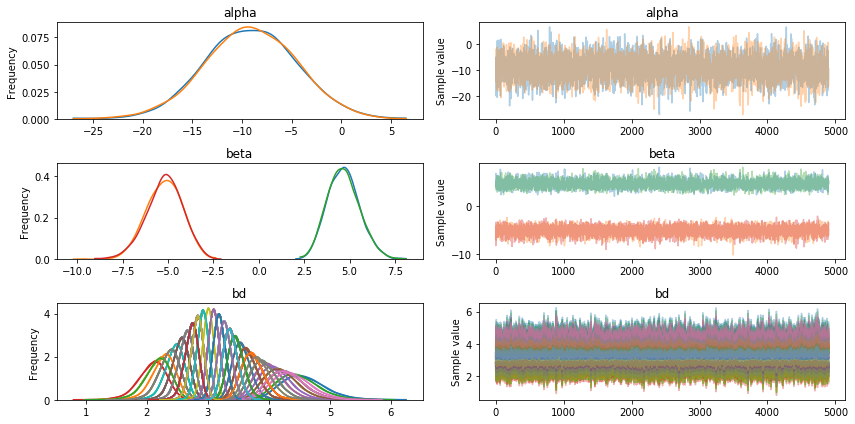

In [10]:
with pm.Model() as model_a:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(yn))
    
    mu = alpha + pm.math.dot(x1, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x1[:,0])
    
    y2 = pm.Bernoulli('y2', p=theta, observed=y1)
    trace = pm.sample(5000)
chain = trace[100:]
varnames = ['alpha', 'beta']
pm.traceplot(chain)

Text(0, 0.5, 'sepal_width')

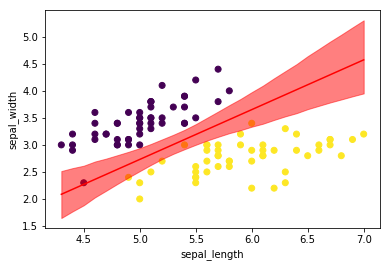

In [11]:
idx = np.argsort(x1[:,0])
bd = chain['bd'].mean(0)[idx]
plt.scatter(x1[:,0], x1[:,1], c=y1)
plt.plot(x1[:,0][idx], bd, color='r')

bd_hpd = pm.hpd(chain['bd'])[idx]
plt.fill_between(x1[:,0][idx], bd_hpd[:,0], bd_hpd[:,1], color='r', alpha=0.5)

plt.xlabel(yn[0])
plt.ylabel(yn[1])

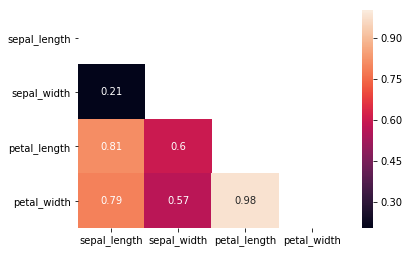

In [15]:
corr = iris[iris['species'] != 'virginica'].corr()
#掩码操作，去除对角线和上三角信息
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(),mask=mask, annot=True)#